In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np
from scipy.stats import gaussian_kde

# Atoms
from ase.io import read

# ML
from kernels import (build_kernel, linear_kernel, gaussian_kernel,
                     linear_kernel_diag, gaussian_kernel_diag,
                     linear_kernel_tri, gaussian_kernel_tri,
                     diag_indices, tri_indices)

# Utilities
import h5py
import json
from tqdm.notebook import tqdm
from project_utils import load_structures_from_hdf5

# Plotting
import matplotlib.pyplot as plt

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
# TODO: generalize for different kernels
# TODO: iterative gaussian KDE
# TODO: wrapper for gaussian_kernel_diag functions

In [4]:
# Data type for loading FPS indices
dt = np.dtype({'names': ['idxs', 'distances'], 'formats': ['i8', 'f8']})

# Distance cutoff for unique environments
unique_cutoff = 1.0E-12

In [5]:
# Histogram bin setup
bin_min = -4
bin_max = 1
n_bins = 101
bin_edges = np.logspace(bin_min, bin_max, n_bins)
dx = np.diff(bin_edges)

In [6]:
# Output file header for histograms
column_labels = 'bin_edges bin_widths probability_density'

In [7]:
# Load SOAP cutoffs
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

# Functions

In [8]:
def structure_histogram(model_file, soaps_A, soaps_A_name='soaps_A', 
                        soaps_B=None, soaps_B_name='soaps_B', 
                        header=None, work_dir='.'):
    
    if soaps_B is None:
        soaps_B_name = soaps_A_name
    
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Distance matrix for different datasets
    if soaps_B is not None:
        
        # Compute kernel diagonals for each dataset
        KAA = gaussian_kernel_diag(soaps_A, soaps_A, gamma=gamma, k=0)
        KAA = np.reshape(KAA, (-1, 1))
        KBB = gaussian_kernel_diag(soaps_B, soaps_B, gamma=gamma, k=0)
        
        # Compute kernel between datasets
        DAB = -2.0*build_kernel(soaps_A, soaps_B, kernel=kernel_type, gamma=gamma)
        
        # Compute kernel distance
        DAB += KAA + KBB 
        DAB = np.sqrt(DAB)
                        
        # Compute minimum distance for each environment in each dataset
        # min_AB = distance from an A to the nearest B for every A
        # min_BA = distance from a B to the nearest A for every B
        DAB_min_AB = np.amin(DAB, axis=1)
        DAB_min_BA = np.amin(DAB, axis=0)

        # Compute distance histograms
        H, _ = np.histogram(DAB, bins=bin_edges, density=True)
        H_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=True)
        H_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=True)

        # Compute KDEs
        #kde = gaussian_kde(DAB)
        #H_kde = kde(bin_edges[0:-1])
        #
        #kde_min_AB = gaussian_kde(DAB_min_AB)
        #H_min_AB_kde = kde_min_AB(bin_edges[0:-1])
        #
        #kde_min_BA = gaussian_kde(DAB_min_BA)
        #H_min_BA_kde = kde_min_BA(bin_edges[0:-1])

        # Save histograms
        header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
        np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_B_name}_histogram_structures.dat', 
                   np.column_stack((bin_edges[0:-1], dx, H)),
                   header=header)
        np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_B_name}_min_histogram_structures.dat', 
                   np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
                   header=header)
        np.savetxt(f'{work_dir}/{soaps_B_name}-{soaps_A_name}_min_histogram_structures.dat',
                   np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
                   header=header)

        # Save KDEs
        #np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_B_name}_kde_structures.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, H)),
        #           header=header)
        #np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_B_name}_min_kde_structures.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, H_min_AB_kde)),
        #           header=header)
        #np.savetxt(f'{work_dir}/{soaps_B_name}-{soaps_A_name}_min_kde_structures.dat',
        #           np.column_stack((bin_edges[0:-1], dx, H_min_BA_kde)),
        #           header=header)
    
    # Distance matrix within same dataset
    else:
        
        # TODO: do this without computing the full kernel (use gaussian_tri)
        # Compute kernel diagonals
        DAB = build_kernel(soaps_A, soaps_A, kernel=kernel_type, gamma=gamma)
        KBB = np.diag(DAB)
        KAA = KBB.reshape((-1, 1))

        # Compute kernel between datasets
        DAB = -2.0*DAB

        # Compute squared kernel distance
        DAB += KAA + KBB
        
        # Compute minimum distance for each environment in each dataset
        # Flatten to remove diagonal
        DAB_min = DAB.flatten()

        # Remove diagonal entries
        diag_idxs = np.arange(0, DAB.size, DAB.shape[0] + 1)
        DAB_min = np.sqrt(np.delete(DAB_min, diag_idxs))

        # Reshape into matrix
        DAB_min = np.reshape(DAB_min, (DAB.shape[0], DAB.shape[0] - 1))
        DAB_min = np.amin(DAB_min, axis=1)

        # Triangular indices
        triu_idxs = np.triu_indices(len(soaps_A), k=1)

        # Compute kernel distance
        DAB = np.sqrt(DAB[triu_idxs])
        
        # Compute distance histograms
        H, _ = np.histogram(DAB, bins=bin_edges, density=True)
        H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)

        # Compute KDEs
        #kde = gaussian_kde(DAB)
        #H_kde = kde(bin_edges[0:-1])
        #
        #kde_min = gaussian_kde(DAB_min)
        #H_min_kde = kde_min(bin_edges[0:-1])

        # Save histograms
        header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
        np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_A_name}_histogram_structures.dat', 
                   np.column_stack((bin_edges[0:-1], dx, H)),
                   header=header)
        np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_A_name}_min_histogram_structures.dat', 
                   np.column_stack((bin_edges[0:-1], dx, H_min)),
                   header=header)

        # Save KDEs
        #np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_A_name}_kde_structures.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, H_kde)),
        #           header=header)
        #np.savetxt(f'{work_dir}/{soaps_A_name}-{soaps_A_name}_min_kde_structures.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, H_min_kde)),
        #           header=header)

# DEEM-DEEM

In [ ]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
    model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
        
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Set header for output file
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels

    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file, dtype=dt)
    deem_unique = deem_unique[deem_unique['distances'] > unique_cutoff]
    idxs = deem_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file, datasets=None, concatenate=False)
    
    # Compute histograms for structures
    structure_histogram(model_file, deem_soaps, soaps_A_name='DEEM_10k',
                         header=header, work_dir=work_dir)
    
    deem_soaps = np.vstack(deem_soaps)
    deem_soaps = deem_soaps[idxs, :]
    
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    DAB_min = np.zeros(len(deem_soaps))
    
    # Distance histogram diagonals
    KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)
    KAA = KBB
    
    # Iteratively build KAB and the distance histogram
    for sdx, soap in enumerate(tqdm(deem_soaps)):
        
        # Compute one row of the kernel
        soap = np.reshape(soap, (1, -1)) # Add extra dimension for cdist in gaussian_kernel
        DAB = -2.0*gaussian_kernel(soap, deem_soaps, gamma=gamma)
        DAB = np.reshape(DAB, (-1)) # Remove extra dimension
        
        # Compute squared distance for that row
        DAB += KAA[sdx] + KBB
        
        # Compute minimum distance for the row, excluding self
        # (np.delete does not modify in-place)
        DAB_min[sdx] = np.sqrt(np.amin(np.delete(DAB, sdx)))
        
        # Compute distance, taking only distances above the main diagonal
        # to avoid zero self-distances and double-counting
        DAB = np.sqrt(DAB[sdx+1:])
        
        # TODO: compute KDE
                
        # Compute histogram
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        
        # Increment histogram
        H += h
     
    # Normalize the histogram
    H /= dx*np.sum(H)
    
    # Compute histogram of minimum distances
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)
    
    # Save histograms
    np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_min_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)
    
    # Save KDEs
    #np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H)),
    #           header=header)
    #np.savetxt(f'{work_dir}/DEEM_10k-DEEM_10k_min_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_min)),
    #           header=header)

In [ ]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

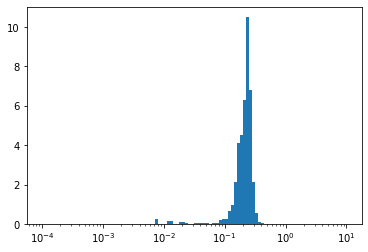

In [29]:
H_min = np.loadtxt('../Processed_Data/Histograms/6.0/DEEM_10k-DEEM_10k_min_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

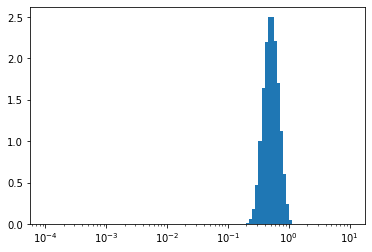

In [30]:
H = np.loadtxt('../Processed_Data/Histograms/6.0/DEEM_10k-DEEM_10k_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# IZA-IZA

In [9]:
# Load IZA cantons
iza_cantons = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', 
                         dtype={'names': ['structures', 'cantons'], 'formats': ['U3', 'i8']})

# Load IZA Si atom counts
n_Si_iza = np.loadtxt('../Processed_Data/IZA_226/n_Si.dat', dtype=int)

struct_cantons = iza_cantons['cantons']
env_cantons = np.repeat(struct_cantons, n_Si_iza)

canton_labels = np.unique(struct_cantons)
print(canton_labels)

[1 2 3 4]


In [10]:
# Load IZA structures to check that cantons are connected to the correct structure
iza = read('../Raw_Data/GULP/IZA_226/IZA.xyz', index=':')
ids = [i.info['Filename'][4:7] for i in iza]
print(all(ids == iza_cantons['structures']))

True


In [11]:
for cutoff in cutoffs:
    
    # Set data files   
    idxs_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
        
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Set header for output file
    header = f'kernel:{kernel_type} gamma:{gamma}\n' + column_labels

    # Load indices of unique environments
    iza_unique = np.loadtxt(idxs_file_iza, dtype=dt)
    iza_unique = iza_unique[iza_unique['distances'] > unique_cutoff]
    idxs_iza = iza_unique['idxs']
    
    # Load unique SOAPs
    iza_soaps = load_structures_from_hdf5(soaps_file_iza, datasets=None, concatenate=False)
    
    # Build histograms for all structures
    structure_histogram(model_file, iza_soaps, soaps_A_name='IZA_226',
                         header=header, work_dir=work_dir)
    
    iza_soaps_stacked = np.vstack(iza_soaps)
    iza_soaps_stacked = iza_soaps_stacked[idxs_iza, :]
    
    # Associate each environment with a structure index
    #split_idxs = np.cumsum(n_Si_iza)
    #cantons = np.zeros(iza_soaps.shape[0], dtype=int)
    #for idx, i in enumerate(idxs_iza):
    #    struct_number = np.nonzero((split_idxs-i) > 0)[0][0]
    #    cantons[idx] = iza_cantons[struct_number]['cantons']
    
    # Compute kernel diagonals
    DAB = gaussian_kernel(iza_soaps_stacked, iza_soaps_stacked, gamma=gamma)
    KBB = np.diag(DAB)
    KAA = KBB.reshape((-1, 1))

    # Compute kernel between datasets
    DAB = -2.0*DAB

    # Compute squared kernel distance
    DAB += KAA + KBB
    
    # Loop over cantons
    for cdx, canton_A in enumerate(canton_labels):
        
        # Get IZA structures in the specified canton
        struct_canton_idxs_A = np.nonzero(struct_cantons == canton_A)[0]
        
        # Get IZA environments in the specified canton
        env_canton_idxs_A = np.nonzero(env_cantons[idxs_iza] == canton_A)[0]
        DAB_canton_A = DAB[env_canton_idxs_A, :]

        # Loop over cantons
        for canton_B in canton_labels[cdx:]:
            
            # Get IZA structures in the specified secondary canton
            struct_canton_idxs_B = np.nonzero(struct_cantons == canton_B)[0]
        
            # Get IZA environments in the specified secondary canton
            env_canton_idxs_B = np.nonzero(env_cantons[idxs_iza] == canton_B)[0]
            DAB_canton_AB = DAB_canton_A[:, env_canton_idxs_B]

            # Self-distances
            if canton_A == canton_B:
                
                # Build histograms for structures,
                # but skip canton 4, which is a single structure (RWY)
                if canton_A != 4:
                    structure_histogram(model_file, 
                                         [iza_soaps[i] for i in struct_canton_idxs_A], 
                                         soaps_A_name=f'IZA_226_{canton_A}',
                                         header=header, work_dir=work_dir)

                # Flatten to remove diagonal
                DAB_canton_min_AB = DAB_canton_AB.flatten()
                
                # Remove diagonal entries
                diag_idxs = np.arange(0, DAB_canton_AB.size, DAB_canton_AB.shape[0] + 1)
                DAB_canton_min_AB = np.sqrt(np.delete(DAB_canton_min_AB, diag_idxs))
                
                # Reshape into matrix
                DAB_canton_min_AB = np.reshape(DAB_canton_min_AB, 
                                               (DAB_canton_AB.shape[0], DAB_canton_AB.shape[0] - 1))
                
                # Compute minimum distance for each environment in each dataset
                DAB_canton_min_AB = np.amin(DAB_canton_min_AB, axis=1)
                
                # Upper triangular indices
                triu_idxs = np.triu_indices(DAB_canton_AB.shape[0], k=1)

                # Compute kernel distance
                DAB_canton_AB = np.sqrt(DAB_canton_AB[triu_idxs])
                
                # Compute distance histograms
                h, _ = np.histogram(DAB_canton_AB, bins=bin_edges, density=True)
                h_min, _ = np.histogram(DAB_canton_min_AB, bins=bin_edges, density=True)
                
                # Compute KDEs
                #kde = gaussian_kde(DAB_canton_AB)
                #h_kde = kde(bin_edges[0:-1])
                #
                #kde_min = gaussian_kde(DAB_canton_min_AB)
                #h_min_kde = kde_min(bin_edges[0:-1])
                
                # Save histograms
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_histogram_environments.dat',
                           np.column_stack((bin_edges[0:-1], dx, h)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_histogram_environments.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min)), header=header)
                
                # Save KDEs
                #np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_kde_environments.dat',
                #           np.column_stack((bin_edges[0:-1], dx, h_kde)), header=header)
                #np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_kde_environments.dat', 
                #           np.column_stack((bin_edges[0:-1], dx, h_min_kde)), header=header)
                
            else:
                
                # Build histograms for structures
                structure_histogram(model_file, 
                             [iza_soaps[i] for i in struct_canton_idxs_A], 
                             soaps_A_name=f'IZA_226_{canton_A}',
                             soaps_B=[iza_soaps[i] for i in struct_canton_idxs_B],
                             soaps_B_name=f'IZA_226_{canton_B}',
                             header=header, work_dir=work_dir)

                # Compute kernel distance
                DAB_canton_AB = np.sqrt(DAB_canton_AB)

                # Compute minimum distance for each environment in each dataset
                # min_AB = distance from an A to the nearest B for every A
                # min_BA = distance from a B to the nearest A for every B
                DAB_canton_min_AB = np.amin(DAB_canton_AB, axis=1)
                DAB_canton_min_BA = np.amin(DAB_canton_AB, axis=0)
                
                # Compute distance histograms
                h, _ = np.histogram(DAB_canton_AB, bins=bin_edges, density=True)
                h_min_AB, _ = np.histogram(DAB_canton_min_AB, bins=bin_edges, density=True)
                h_min_BA, _ = np.histogram(DAB_canton_min_BA, bins=bin_edges, density=True)
                
                # Compute KDEs
                #kde = gaussian_kde(DAB_canton_AB)
                #h_kde = kde(bin_edges[0:-1])
                #
                #kde_min_AB = gaussian_kde(DAB_canton_min_AB)
                #h_min_AB_kde = kde_min_AB(bin_edges[0:-1])
                #
                #kde_min_BA = gaussian_kde(DAB_canton_min_BA)
                #h_min_BA_kde = kde_min_BA(bin_edges[0:-1])
                
                # Save histograms
                header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_histogram_environments.dat',
                           np.column_stack((bin_edges[0:-1], dx, h)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_histogram_environments.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min_AB)), header=header)
                np.savetxt(f'{work_dir}/IZA_226_{canton_B}-IZA_226_{canton_A}_min_histogram_environments.dat', 
                           np.column_stack((bin_edges[0:-1], dx, h_min_BA)), header=header)
                
                # Save KDEs
                #np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_kde_environments.dat',
                #           np.column_stack((bin_edges[0:-1], dx, h_kde)), header=header)
                #np.savetxt(f'{work_dir}/IZA_226_{canton_A}-IZA_226_{canton_B}_min_kde_environments.dat', 
                #           np.column_stack((bin_edges[0:-1], dx, h_min_AB_kde)), header=header)
                #np.savetxt(f'{work_dir}/IZA_226_{canton_B}-IZA_226_{canton_A}_min_kde_environments.dat', 
                #           np.column_stack((bin_edges[0:-1], dx, h_min_BA_kde)), header=header)
        
    # Compute histograms on whole IZA database
    # Flatten to remove diagonal            
    DAB_min = DAB.flatten()
        
    # Remove diagonal entries
    diag_idxs = np.arange(0, DAB.size, DAB.shape[0] + 1)
    DAB_min = np.sqrt(np.delete(DAB_min, diag_idxs))
    
    # Reshape into matrix
    DAB_min = np.reshape(DAB_min, (DAB.shape[0], DAB.shape[0] - 1))
    
    # Compute minimum distance for each environment
    DAB_min = np.amin(DAB_min, axis=1)
    
    # Triangular indices
    triu_idxs = np.triu_indices(iza_soaps_stacked.shape[0], k=1)
    
    # Compute kernel distance
    DAB = np.sqrt(DAB[triu_idxs])

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)
    
    # Compute KDEs
    #kde = gaussian_kde(DAB)
    #H_kde = kde(bin_edges[0:-1])
    #
    #kde_min = gaussian_kde(DAB_min)
    #H_min_kde = kde_min(bin_edges[0:-1])

    # Save histograms
    np.savetxt(f'{work_dir}/IZA_226-IZA_226_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/IZA_226-IZA_226_min_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)
    
    # Save KDEs
    #np.savetxt(f'{work_dir}/IZA_226-IZA_226_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_kde)),
    #           header=header)
    #np.savetxt(f'{work_dir}/IZA_226-IZA_226_min_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_min_kde)),
    #           header=header)

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


**NOTE:** We will probably get an error in the above cell with the 4th canton (RWY), as the minimum distances might all be smaller than the cutoff, and therefore the histogram will return all NaNs

In [ ]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

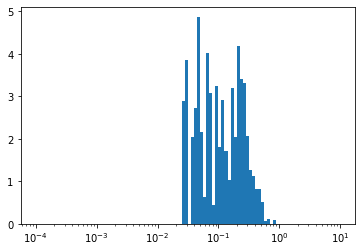

In [31]:
H_min = np.loadtxt('../Processed_Data/Histograms/6.0/IZA_226-IZA_226_min_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

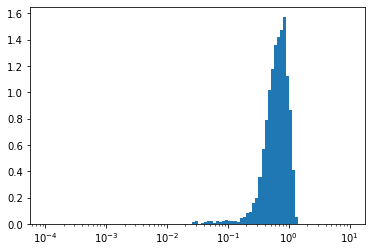

In [32]:
H = np.loadtxt('../Processed_Data/Histograms/6.0/IZA_226-IZA_226_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# COD-COD

In [ ]:
for cutoff in cutoffs:
    
    # Set data files        
    idxs_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
        
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Set header for output file
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
     
    # Load indices of unique environments
    cod_unique = np.loadtxt(idxs_file_cod, dtype=dt)
    cod_unique = cod_unique[cod_unique['distances'] > unique_cutoff]
    idxs_cod = cod_unique['idxs']
    
    # Load unique SOAPs
    cod_soaps = load_structures_from_hdf5(soaps_file_cod, datasets=None, concatenate=False)
    
    # Build histograms for structures
    structure_histogram(model_file, cod_soaps, soaps_A_name='COD_196',
                         header=header, work_dir=work_dir)
    
    cod_soaps = np.vstack(cod_soaps)
    cod_soaps = cod_soaps[idxs_cod, :]
    
    # Compute kernel diagonals
    DAB = gaussian_kernel(cod_soaps, cod_soaps, gamma=gamma)
    KBB = np.diag(DAB)
    KAA = KBB.reshape((-1, 1))

    # Compute kernel between datasets
    DAB = -2.0*DAB

    # Compute squared kernel distance
    DAB += KAA + KBB
    
    # Compute minimum distance for each environment in each dataset
    # Flatten to remove diagonal
    DAB_min = DAB.flatten()
    
    # Remove diagonal entries
    diag_idxs = np.arange(0, DAB.size, DAB.shape[0] + 1)
    DAB_min = np.sqrt(np.delete(DAB_min, diag_idxs))
    
    # Reshape into matrix
    DAB_min = np.reshape(DAB_min, (DAB.shape[0], DAB.shape[0] - 1))
    DAB_min = np.amin(DAB_min, axis=1)
    
    # Triangular indices
    triu_idxs = np.triu_indices(cod_soaps.shape[0], k=1)
    
    # Compute kernel distance
    DAB = np.sqrt(DAB[triu_idxs])

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min, _ = np.histogram(DAB_min, bins=bin_edges, density=True)
    
    # Compute KDEs
    #kde = gaussian_kde(DAB)
    #H_kde = kde(bin_edges[0:-1])
    #
    #kde_min = gaussian_kde(DAB_min)
    #H_min_kde = kde_min(bin_edges[0:-1])

    # Save histograms
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
    np.savetxt(f'{work_dir}/COD_196-COD_196_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/COD_196-COD_196_min_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min)),
               header=header)
    
    # Save KDEs
    #np.savetxt(f'{work_dir}/COD_196-COD_196_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_kde)),
    #           header=header)
    #np.savetxt(f'{work_dir}/COD_196-COD_196_min_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_min_kde)),
    #           header=header)

In [ ]:
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
H_min = np.loadtxt('../Processed_Data/Histograms/6.0/COD_196-COD_196_min_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H_min, width=dx, align='edge')
plt.xscale('log')
plt.show()

In [ ]:
H = np.loadtxt('../Processed_Data/Histograms/6.0/COD_196-COD_196_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# IZA-DEEM

In [ ]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        
    idxs_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_iza = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
        
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Set header for output file
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels

    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file_deem, dtype=dt)
    deem_unique = deem_unique[deem_unique['distances'] > unique_cutoff]
    idxs_deem = deem_unique['idxs']
    
    iza_unique = np.loadtxt(idxs_file_iza, dtype=dt)
    iza_unique = iza_unique[iza_unique['distances'] > unique_cutoff]
    idxs_iza = iza_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file_deem, datasets=None, concatenate=False)
    iza_soaps = load_structures_from_hdf5(soaps_file_iza, datasets=None, concatenate=False)
    
    # Build histograms for structures
    structure_histogram(model_file, iza_soaps, soaps_A_name='IZA_226',
                         soaps_B=deem_soaps, soaps_B_name='DEEM_10k',
                         header=header, work_dir=work_dir)
    
    deem_soaps = np.vstack(deem_soaps)
    deem_soaps = deem_soaps[idxs_deem, :]
    
    iza_soaps_stacked = np.vstack(iza_soaps)
    iza_soaps_stacked = iza_soaps_stacked[idxs_iza, :]
    
    # Associate each environment with a structure index
    #split_idxs = np.cumsum(n_Si_iza)
    #cantons = np.zeros(iza_soaps.shape[0], dtype=int)
    #for idx, i in enumerate(idxs_iza):
    #    struct_number = np.nonzero((split_idxs-i) > 0)[0][0]
    #    cantons[idx] = iza_cantons[struct_number]['cantons']
        
    # Initialize histogram bins
    H = np.zeros(n_bins-1)
    H_min_AB = np.zeros(n_bins-1)
    H_min_BA = np.zeros(n_bins-1)
    
    # Loop over cantons
    for canton in tqdm(canton_labels):
        
        # Get IZA structures in the specified canton
        canton_idxs = np.nonzero(struct_cantons == canton)[0]
        
        # Compute histograms for structures
        structure_histogram(model_file, 
                             [iza_soaps[i] for i in canton_idxs], 
                             soaps_A_name=f'IZA_226_{canton}',
                             soaps_B=deem_soaps, soaps_B_name='DEEM_10k',
                             header=header, work_dir=work_dir)
        
        # Get IZA environments in the specified canton
        canton_idxs = np.nonzero(env_cantons[idxs_iza] == canton)[0]
        
        # Compute kernel diagonals for each dataset
        # A = IZA
        # B = DEEM
        KAA = gaussian_kernel_diag(iza_soaps_stacked[canton_idxs], 
                                   iza_soaps_stacked[canton_idxs], 
                                   gamma=gamma, k=0)
        KAA = np.reshape(KAA, (-1, 1))
        KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)

        # Compute kernel between datasets
        DAB = -2.0*gaussian_kernel(iza_soaps_stacked[canton_idxs], 
                                   deem_soaps, 
                                   gamma=gamma)

        # Compute kernel distance
        DAB += KAA + KBB 
        DAB = np.sqrt(DAB)

        # Compute minimum distance for each environment in each dataset
        # min_AB = distance from an A to the nearest B for every A
        # min_BA = distance from a B to the nearest A for every B
        DAB_min_AB = np.amin(DAB, axis=1)
        DAB_min_BA = np.amin(DAB, axis=0)

        # Compute cantonal distance histograms
        h, _ = np.histogram(DAB, bins=bin_edges, density=False)
        h_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=False)
        h_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=False)
                        
        # Increment total histograms
        H += h
        H_min_AB += h_min_AB
        H_min_BA += h_min_BA
        
        # Normalize cantonal histograms 
        # (do without "/=" b/c need to promote to float)
        h = h / (dx*np.sum(h))
        h_min_AB = h_min_AB / (dx*np.sum(h_min_AB))
        h_min_BA = h_min_BA / (dx*np.sum(h_min_BA))
        
        # Save cantonal histograms
        np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_histogram_environments.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h)),
                   header=header)
        np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_min_histogram_environments.dat', 
                   np.column_stack((bin_edges[0:-1], dx, h_min_AB)),
                   header=header)
        np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_{canton}_min_histogram_environments.dat',
                   np.column_stack((bin_edges[0:-1], dx, h_min_BA)),
                   header=header)
        
        # Save cantonal histograms
        #np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_kde_environments.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, h)),
        #           header=header)
        #np.savetxt(f'{work_dir}/IZA_226_{canton}-DEEM_10k_min_kde_environments.dat', 
        #           np.column_stack((bin_edges[0:-1], dx, h_min_AB)),
        #           header=header)
        #np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_{canton}_min_kde_environments.dat',
        #           np.column_stack((bin_edges[0:-1], dx, h_min_BA)),
        #           header=header)
        
    # Normalize the total histograms
    H /= dx*np.sum(H)
    H_min_AB /= dx*np.sum(H_min_AB)
    H_min_BA /= dx*np.sum(H_min_BA)
    
    # Save histograms
    np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_min_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_min_histogram_environments.dat',
               np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
               header=header)
    
    # Save KDEs
    #np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H)),
    #           header=header)
    #np.savetxt(f'{work_dir}/IZA_226-DEEM_10k_min_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
    #           header=header)
    #np.savetxt(f'{work_dir}/DEEM_10k-IZA_226_min_kde_environments.dat',
    #           np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
    #           header=header)

In [ ]:
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

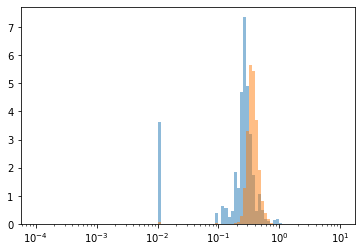

In [33]:
H_min_AB = np.loadtxt('../Processed_Data/Histograms/6.0/IZA_226-DEEM_10k_min_histogram_structures.dat')[:, -1]
H_min_BA = np.loadtxt('../Processed_Data/Histograms/6.0/DEEM_10k-IZA_226_min_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

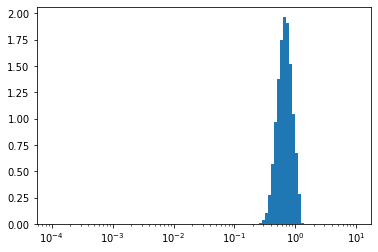

In [34]:
H = np.loadtxt('../Processed_Data/Histograms/6.0/IZA_226-DEEM_10k_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

# COD-DEEM

In [ ]:
for cutoff in cutoffs:
    
    # Set data files
    idxs_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_deem = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
        
    idxs_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/FPS_unique.idxs'
    soaps_file_cod = f'../Processed_Data/COD_196onDEEM_10k/Data/{cutoff}/soaps.hdf5'
    
    model_file = f'../Processed_Data/Models/{cutoff}/Kernel_Models/Gaussian/KRR/volumes_mae_parameters.json'
    
    # Set working directory
    work_dir = f'../Processed_Data/Histograms/{cutoff}'
    if not os.path.exists(work_dir):
        os.makedirs(work_dir)
        
    # Load kernel parameters
    with open(model_file, 'r') as f:
        model_dict = json.load(f)
        
    kernel_type = model_dict['kernel_type']
    gamma = model_dict['gamma']
    
    # Set header for output file
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
     
    # Load indices of unique environments
    deem_unique = np.loadtxt(idxs_file_deem, dtype=dt)
    deem_unique = deem_unique[deem_unique['distances'] > unique_cutoff]
    idxs_deem = deem_unique['idxs']
    
    cod_unique = np.loadtxt(idxs_file_cod, dtype=dt)
    cod_unique = cod_unique[cod_unique['distances'] > unique_cutoff]
    idxs_cod = cod_unique['idxs']
    
    # Load unique SOAPs
    deem_soaps = load_structures_from_hdf5(soaps_file_deem, datasets=None, concatenate=False)
    cod_soaps = load_structures_from_hdf5(soaps_file_cod, datasets=None, concatenate=False)
    
    # Build histograms for structures
    structure_histogram(model_file, cod_soaps, soaps_A_name='COD_196',
                         soaps_B=deem_soaps, soaps_B_name='DEEM_10k',
                         header=header, work_dir=work_dir)
    
    deem_soaps = np.vstack(deem_soaps)
    deem_soaps = deem_soaps[idxs_deem, :]
    
    cod_soaps = np.vstack(cod_soaps)
    cod_soaps = cod_soaps[idxs_cod, :]
    
    # Compute kernel diagonals for each dataset
    # A = COD
    # B = DEEM
    KAA = gaussian_kernel_diag(cod_soaps, cod_soaps, gamma=gamma, k=0)
    KAA = np.reshape(KAA, (-1, 1))
    KBB = gaussian_kernel_diag(deem_soaps, deem_soaps, gamma=gamma, k=0)

    # Compute kernel between datasets
    DAB = -2.0*gaussian_kernel(cod_soaps, deem_soaps, gamma=gamma)

    # Compute kernel distance
    DAB += KAA + KBB 
    DAB = np.sqrt(DAB)

    # Compute minimum distance for each environment in each dataset
    # min_AB = distance from an A to the nearest B for every A
    # min_BA = distance from a B to the nearest A for every B
    DAB_min_AB = np.amin(DAB, axis=1)
    DAB_min_BA = np.amin(DAB, axis=0)

    # Compute distance histograms
    H, _ = np.histogram(DAB, bins=bin_edges, density=True)
    H_min_AB, _ = np.histogram(DAB_min_AB, bins=bin_edges, density=True)
    H_min_BA, _ = np.histogram(DAB_min_BA, bins=bin_edges, density=True)
    
    # Compute KDEs
    #kde = gaussian_kde(DAB)
    #H_kde = kde(bin_edges[0:-1])
    #
    #kde_min_AB = gaussian_kde(DAB_min_AB)
    #H_min_AB_kde = kde_min_AB(bin_edges[0:-1])
    #
    #kde_min_BA = gaussian_kde(DAB_min_BA)
    #H_min_BA_kde = kde_min_BA(bin_edges[0:-1])

    # Save histograms
    header = f'kernel: {kernel_type} gamma: {gamma}\n' + column_labels
    np.savetxt(f'{work_dir}/COD_196-DEEM_10k_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H)),
               header=header)
    np.savetxt(f'{work_dir}/COD_196-DEEM_10k_min_histogram_environments.dat', 
               np.column_stack((bin_edges[0:-1], dx, H_min_AB)),
               header=header)
    np.savetxt(f'{work_dir}/DEEM_10k-COD_196_min_histogram_environments.dat',
               np.column_stack((bin_edges[0:-1], dx, H_min_BA)),
               header=header)
    
    # Save KDEs
    #np.savetxt(f'{work_dir}/COD_196-DEEM_10k_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H)),
    #           header=header)
    #np.savetxt(f'{work_dir}/COD_196-DEEM_10k_min_kde_environments.dat', 
    #           np.column_stack((bin_edges[0:-1], dx, H_min_AB_kde)),
    #           header=header)
    #np.savetxt(f'{work_dir}/DEEM_10k-COD_196_min_kde_environments.dat',
    #           np.column_stack((bin_edges[0:-1], dx, H_min_BA_kde)),
    #           header=header)

In [ ]:
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

In [ ]:
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()

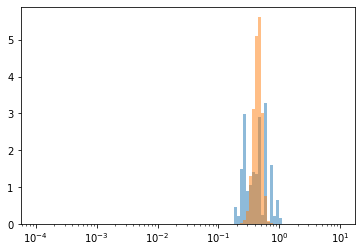

In [35]:
H_min_AB = np.loadtxt('../Processed_Data/Histograms/6.0/COD_196-DEEM_10k_min_histogram_structures.dat')[:, -1]
H_min_BA = np.loadtxt('../Processed_Data/Histograms/6.0/DEEM_10k-COD_196_min_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H_min_AB, width=dx, align='edge', alpha=0.5)
plt.bar(bin_edges[0:-1], H_min_BA, width=dx, align='edge', alpha=0.5)
plt.xscale('log')
plt.show()

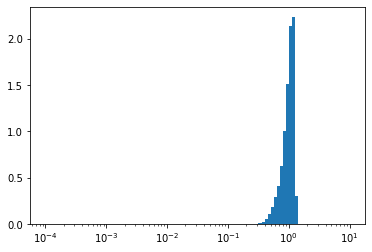

In [36]:
H = np.loadtxt('../Processed_Data/Histograms/6.0/COD_196-DEEM_10k_histogram_structures.dat')[:, -1]
plt.bar(bin_edges[0:-1], H, width=dx, align='edge')
plt.xscale('log')
plt.show()